## Notebook that does all the preproccesing for the Machine learning models


### Import all libraries

In [1]:
# %% import libraries:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#rdkit libs:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statistics import mean


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pandas.plotting import scatter_matrix 


### Molecular Descriptor from SMILES
In this notebook, we calculate molecular descriptors from SMILES strings using RDKit. The process involves:

The function get_descriptor_names_and_functions() retrieves descriptor names and functions from RDKit and stores them in a DataFrame.
Convert SMILES to Descriptors:

get_general_descriptors_from_smiles(smiles) converts a SMILES string to an RDKit molecule and calculates its descriptors. If conversion fails, it returns None for each descriptor.
Add Descriptors to DataFrame:

smiles_to_descriptors_for_df(df, show_head=False) computes descriptors for each SMILES string in a DataFrame and adds them as new columns. The show_head parameter, when set to True, displays the first few rows of the updated DataFrame.

In [2]:
#load the data
df_tested_mol = pd.read_csv('tested_molecules.csv')
df_backup_original_data=df_tested_mol.copy()

In [3]:

# Function to get descriptor names and functions from RDKit's Descriptors module
def get_descriptor_names_and_functions():
    # Extract descriptor names and functions
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    descriptor_functions = [desc[1] for desc in Descriptors.descList]
    
    # Create a DataFrame with descriptor names and their corresponding functions
    df_descriptors = pd.DataFrame({'names': descriptor_names, 'functions': descriptor_functions})
    
    return df_descriptors

# Function to convert SMILES strings to molecular descriptors
def get_general_descriptors_from_smiles(smiles):
    # Convert SMILES string to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    # Get DataFrame of descriptor names and functions
    df_general_descriptors = get_descriptor_names_and_functions()
    # If molecule conversion is successful
    if mol:
        # Calculate each descriptor using the molecule object
        descriptors = [func(mol) for func in df_general_descriptors["functions"]]
        return descriptors
    else:
        # If molecule conversion fails, return None for each descriptor
        return [None] * len(df_general_descriptors["functions"])

# Function to convert a DataFrame of SMILES strings to descriptors and add them to the DataFrame
def smiles_to_descriptors_for_df(df, show_head=False):
    # Create a copy of the input DataFrame
    df = df.copy()
    # Get DataFrame of descriptor names and functions
    df_general_descriptors = get_descriptor_names_and_functions()

    # Create an empty DataFrame to store the descriptors
    df_descriptors = pd.DataFrame(columns=df_general_descriptors["names"])
    # Iterate over each SMILES string in the input DataFrame
    for smls in df["SMILES"]:
        # Calculate descriptors for each SMILES string
        Descriptors = get_general_descriptors_from_smiles(smls)
        # Create a DataFrame for the new descriptors
        new_descriptors = pd.DataFrame([Descriptors], columns=df_general_descriptors['names'])
        # Concatenate the new descriptors to the descriptors DataFrame
        df_descriptors = pd.concat([df_descriptors, new_descriptors], axis=0, ignore_index=True)
    
    # Concatenate the original DataFrame with the descriptors DataFrame
    df = pd.concat([df, df_descriptors], axis=1)

    # Optionally print the head of the DataFrame
    if show_head:
        print(df.head())
    
    return df



In [4]:

# Apply the function to compute descriptors for the DataFrame containing SMILES strings
df_molecules_with_descriptors = smiles_to_descriptors_for_df(df_tested_mol)

# Set the 'SMILES' column as the index of the resulting DataFrame
df_molecules_with_descriptors = df_molecules_with_descriptors.set_index('SMILES')

## check for high correlation

In [5]:
# Drop the columns 'PKM2_inhibition' and 'ERK2_inhibition' from the DataFrame
descriptor_data = df_molecules_with_descriptors.drop(columns=['PKM2_inhibition', 'ERK2_inhibition'])

# Calculate the correlation matrix for the descriptor data
corr_matrix = descriptor_data.corr()

# Initialize a list to store pairs of highly correlated descriptors
high_corr_pairs = []

# Iterate over the upper triangle of the correlation matrix to find highly correlated pairs
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.95:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            high_corr_pairs.append((colname_i, colname_j, corr_value))

# Print the pairs of descriptors with high correlation
print("Highly correlated pairs (correlation > 0.95):")
for col1, col2, corr in high_corr_pairs:
    print(f"Pair: {col1} and {col2} with correlation of {corr:.2f}")

Highly correlated pairs (correlation > 0.95):
Pair: MaxAbsEStateIndex and MaxEStateIndex with correlation of 1.00
Pair: MolWt and HeavyAtomMolWt with correlation of 1.00
Pair: MolWt and ExactMolWt with correlation of 1.00
Pair: MolWt and Chi0 with correlation of 0.97
Pair: MolWt and Chi0v with correlation of 0.97
Pair: MolWt and Chi1 with correlation of 0.96
Pair: MolWt and LabuteASA with correlation of 0.98
Pair: HeavyAtomMolWt and ExactMolWt with correlation of 1.00
Pair: HeavyAtomMolWt and Chi0 with correlation of 0.96
Pair: HeavyAtomMolWt and Chi0v with correlation of 0.96
Pair: HeavyAtomMolWt and LabuteASA with correlation of 0.97
Pair: ExactMolWt and Chi0 with correlation of 0.97
Pair: ExactMolWt and Chi0v with correlation of 0.97
Pair: ExactMolWt and Chi1 with correlation of 0.96
Pair: ExactMolWt and LabuteASA with correlation of 0.98
Pair: MaxPartialCharge and MinAbsPartialCharge with correlation of 0.98
Pair: MinPartialCharge and MaxAbsPartialCharge with correlation of -0.99
P

## scaling

<AxesSubplot:>

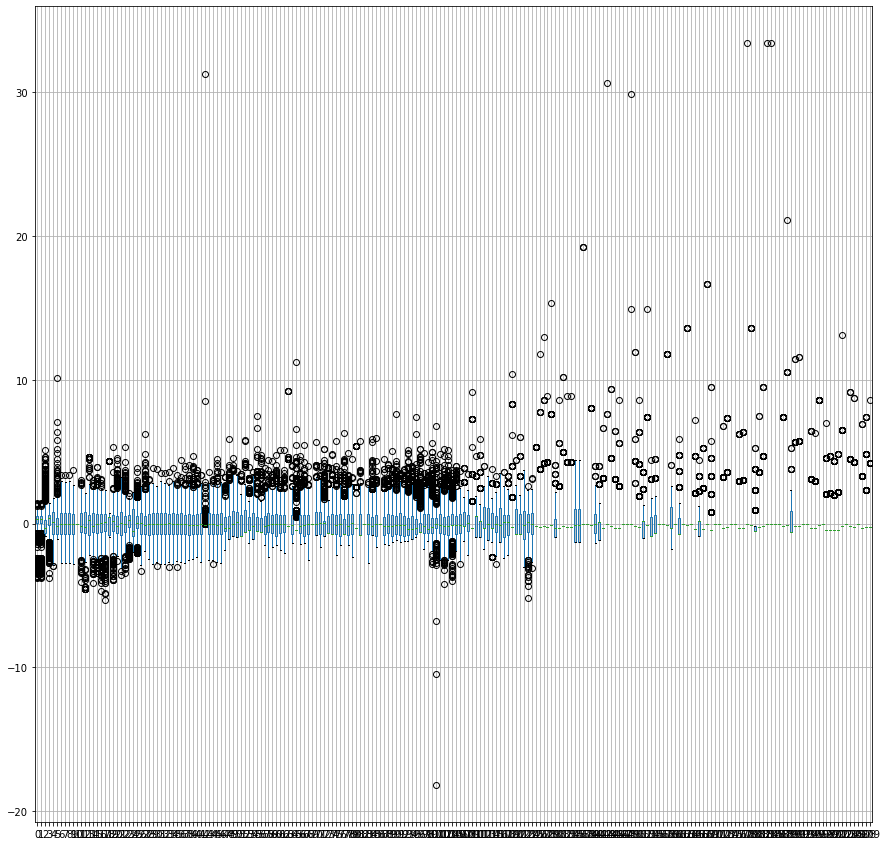

In [6]:
# Standardize the descriptor data using StandardScaler
scaling = StandardScaler()
scaling.fit(descriptor_data)

# Transform the descriptor data
Scaled_data = scaling.transform(descriptor_data)

# Create a DataFrame from the scaled data and display a boxplot
pd.DataFrame(Scaled_data).boxplot(figsize=(15, 15))

## perform PCA

In [7]:
pca=PCA()
transformed_data=pca.fit_transform(Scaled_data)
variances=pd.DataFrame(pca.explained_variance_ratio_*100)
variances.index+=1
#variances.head(20)

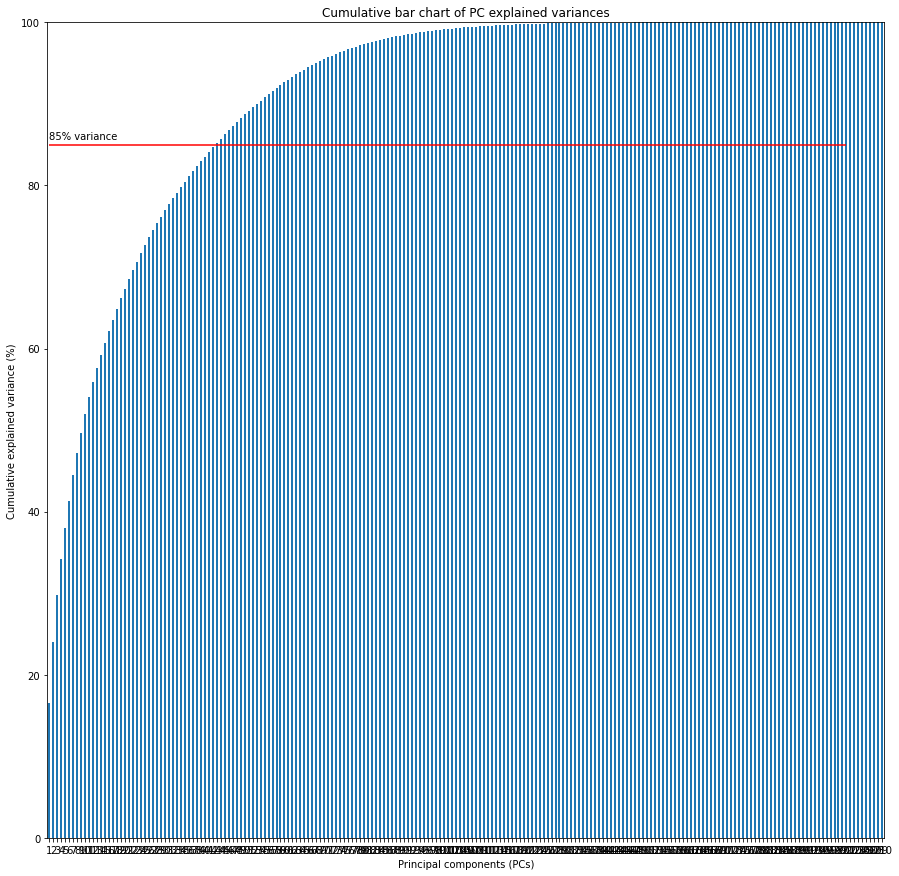

In [8]:
# Calculate cumulative variances
cumulative_variances = variances.cumsum()

# Plot cumulative variances as a bar chart
cumulative_variances.plot.bar(rot=0, legend=False, figsize=(15, 15), ylim=(0, 100))

# Set plot title, labels, and additional annotations
plt.title('Cumulative bar chart of PC explained variances')
plt.ylabel('Cumulative explained variance (%)')
plt.xlabel('Principal components (PCs)')
plt.hlines(xmin=0, xmax=200, y=85, color='red')
plt.text(0, 86, '85% variance', ha='left', va='center')

# Show the plot
plt.show()

## PCA loadings
display the PC1 and PC2 components

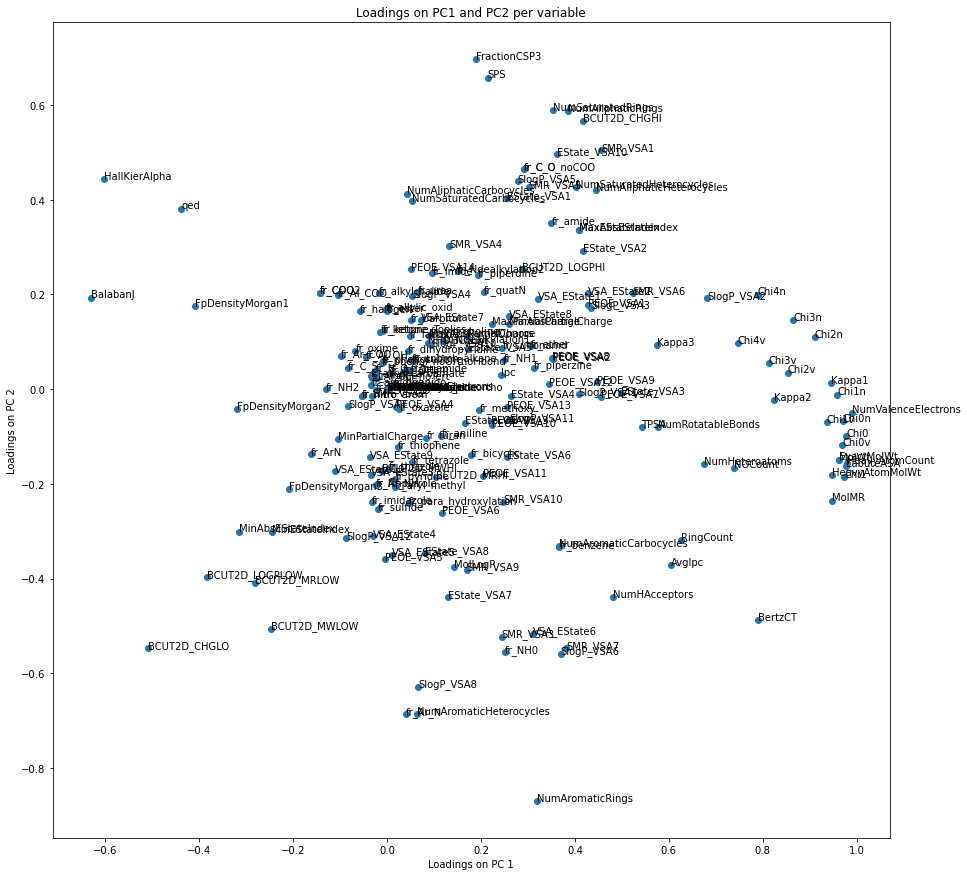

In [9]:
# Calculate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=descriptor_data.columns, columns=list(range(1, len(variances) + 1)))

# Extract loadings for PC1 and PC2
PC1_loadings = loading_matrix[1]
PC2_loadings = loading_matrix[2]
labels = descriptor_data.columns

# Create scatter plot of loadings on PC1 and PC2
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(x=PC1_loadings, y=PC2_loadings)
ax.set_xlabel('Loadings on PC 1')
ax.set_ylabel('Loadings on PC 2')
ax.set_title('Loadings on PC1 and PC2 per variable')

# Annotate points with variable labels
for i in range(len(labels)):
    ax.annotate(labels[i], (PC1_loadings[i], PC2_loadings[i]))

# Show the plot
plt.show()

## scale loading values
loading values get scaled with their variance to find its effect on the total computation

In [10]:
list_of_descriptors = []
countings = {}

# Iterate over each principal component
for PC in range(1, 200):
    # Select descriptors with absolute loading greater than 0.05 for the current PC
    descriptors = loading_matrix[abs(loading_matrix[PC]) > 0.05][PC].index
    
    # Calculate and accumulate contribution to variance for each descriptor
    for descriptor in descriptors:
        if descriptor not in countings.keys():
            countings[descriptor] = float(abs(loading_matrix[loading_matrix.index == descriptor][PC])) * variances.iloc[PC - 1]
        countings[descriptor] += float(abs(loading_matrix[loading_matrix.index == descriptor][PC])) * variances.iloc[PC - 1]
        
        # Add descriptor to the list if not already included
        if descriptor not in list_of_descriptors:
            list_of_descriptors.append(descriptor)

# Create a DataFrame from the accumulated contributions and sort by descending order
loading_values = pd.DataFrame.from_dict(countings, orient='index').sort_values(by=0, ascending=False)

# Display the top 20 descriptors based on their contribution to variance
#loading_values.head(20)

## remove the values with high correlation.
 The one with the lowest loading gets removed.

In [11]:
removed_descriptors = set()

# Iterate over pairs of highly correlated descriptors
for col1, col2, corr in high_corr_pairs:
    # Skip if either descriptor has already been marked for removal
    if col1 in removed_descriptors or col2 in removed_descriptors:
        continue
    
    # Get cumulative loading values for both descriptors
    loading_col1 = loading_values.loc[col1, 0]
    loading_col2 = loading_values.loc[col2, 0]
    
    # Remove the descriptor with the lower cumulative loading
    if loading_col1 < loading_col2:
        removed_descriptors.add(col1)
    else:
        removed_descriptors.add(col2)

# Print descriptors to be removed due to high correlation
print("Descriptors to be removed due to high correlation:")
for descriptor in removed_descriptors:
    print(descriptor)

# Create a cleaned DataFrame without the removed descriptors
descriptor_data_cleaned = descriptor_data.drop(columns=removed_descriptors)

# Display the first 20 rows of the cleaned DataFrame
#descriptor_data_cleaned.head(20)

Descriptors to be removed due to high correlation:
Chi1
Chi4v
Chi1n
Chi2n
MolWt
ExactMolWt
Chi2v
Chi0
MaxAbsPartialCharge
Chi4n
MaxEStateIndex
LabuteASA
Chi0v
MolMR
MaxPartialCharge


## save the data

In [16]:
descriptor_data_cleaned['ERK2_inhibition']=df_molecules_with_descriptors['ERK2_inhibition']
descriptor_data_cleaned['PKM2_inhibition']=df_molecules_with_descriptors['PKM2_inhibition']
descriptor_data_cleaned.to_csv('cleaned_descriptor_data')

## Compute the same descriptors for the untested data set and save them 

In [17]:
df_untested_mol = pd.read_csv('tested_molecules.csv')
df_untested_molecules_with_descriptors=smiles_to_descriptors_for_df(df_untested_mol)
df_untested_molecules_with_descriptors=df_untested_molecules_with_descriptors.set_index('SMILES')
export_data=df_untested_molecules_with_descriptors.drop(columns=removed_descriptors)
export_data['ERK2_inhibition']=df_untested_molecules_with_descriptors['ERK2_inhibition'].copy()
export_data['PKM2_inhibition']=df_untested_molecules_with_descriptors['PKM2_inhibition'].copy()
export_data.to_csv('cleaned_descriptor_data_untested')

## fingerprints for tested molecules
In this section, we convert a list of SMILES strings into molecular fingerprints using RDKit's Morgan Fingerprints

In [14]:

data = df_molecules_with_descriptors

#find the molcule names
molecules = list(data.index)

# Initialize an empty list to store the fingerprints
fingerprints = []

# Iterate over each SMILES string to compute the Morgan fingerprint
for smiles in molecules:
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fingerprints.append(fp)

# Convert the fingerprints to a list of binary strings (integers)
fingerprints_int = [list(fp.ToBitString()) for fp in fingerprints]

# Create a DataFrame from the fingerprints, with each bit as a separate column
df = pd.DataFrame(fingerprints_int, columns=[f'Bit_{i+1}' for i in range(len(fingerprints_int[0]))])

# Set the index of the DataFrame to the SMILES strings
df.index = molecules

# Display the first few rows of the DataFrame
#df.head()

In [15]:
df.to_csv('fingerprint_data_tested')

## Fingerprints for untested molecules

In [19]:
data = df_untested_molecules_with_descriptors

#find the molcule names
molecules = list(data.index)

# Initialize an empty list to store the fingerprints
fingerprints = []

# Iterate over each SMILES string to compute the Morgan fingerprint
for smiles in molecules:
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fingerprints.append(fp)

# Convert the fingerprints to a list of binary strings (integers)
fingerprints_int = [list(fp.ToBitString()) for fp in fingerprints]

# Create a DataFrame from the fingerprints, with each bit as a separate column
df = pd.DataFrame(fingerprints_int, columns=[f'Bit_{i+1}' for i in range(len(fingerprints_int[0]))])

# Set the index of the DataFrame to the SMILES strings
df.index = molecules
df.to_csv('fingerprint_data_untested')